# Objective

In this notebook, we will fine-tune a pre-trained BERT model to perform sentiment analysis on a twitter data.

# Table of Contents

1. Setup
  - Using Google Colab for training
  - Installing the Hugging Face's Transformers Library
2. Loading & Understanding BERT
  - Download Pretrained BERT model
  - Tokenization and Input Formatting
  - Understanding Input and Output
3. Preparing Data
  - Loading and Reading Twitter Airline
  - Text Cleaning
  - Preparing Input and Output Data
  - Training and Validation Data
  - Define Dataloaders
4. Model Finetuning
  - Approach: Fine-Tuning Only Head
  - Define Model Architecture
  - Define Optimizer and Loss function
  - Model Training and Evaluation
  - Train the Model
  - Model Evaluation


# 1. Setup


## 1.1 Using Google Colab for training

Google Colab offers free GPUs and TPUs! Since we are going to train a large neural network, it's best to take advantage of the GPU/TPU (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:


```
Runtime -> Change Runtime -> GPU
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.


In [2]:
#import torch library
import torch

# check GPU availability
if torch.cuda.is_available():
    # select GPU
    device = torch.device("cuda")

device

device(type='cuda')

In [3]:
# check GPU name
torch.cuda.get_device_name(0)

'Tesla T4'

## 1.2. Installing the Hugging Face's Transformers Library

Hugging Face 🤗 is the one of the most popular Natural Language Processing communities for deep learning researchers, hands-on practitioners and educators. It provides State of Art architectures for everyone.


The Transformers library (formerly known as pytorch-transformers) provides a wide range of general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, etc) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with a wide range of pretrained models in 100+ languages and deep interoperability between TensorFlow 2.0 and PyTorch.

In [4]:
#install hugging face transformers
!pip install transformers

# 2. Loading & Understanding BERT

##2.1 Download Pretrained BERT model

We will use the uncased pre-trained version of the BERT base model. It was trained on lower-cased English text.

You can find more pre-trained models here https://huggingface.co/transformers/pretrained_models.html

In [5]:
from transformers import BertModel

# download bert pretrained model
bert = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
# print bert architecture
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

##2.2 Tokenization and Input Formatting

**Download BERT Tokenizer**


In [7]:
#importing fast "BERT" tokenizer
from transformers import BertTokenizerFast

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


**Steps Followed for Input Formatting**

1. Tokenization

2. Special Tokens

  * Prepend the `[CLS]` token to the start of the sequence.
  * Append the `[SEP]` token to the end of the sequence.

3. Pad sequences

4. Converting tokens to integers

5. Create Attention masks to avoid pad tokens

In [8]:
#input text
text = "Jim Henson was a puppeteer"

sent_id = tokenizer.encode(text,
                           # add [CLS] and [SEP] tokens
                           add_special_tokens=True,
                           # specify maximum length for the sequences
                           max_length = 10,
                           truncation = True,
                           # add pad tokens to the right side of the sequence
                           pad_to_max_length='right')

# print integer sequence
print("Integer Sequence: {}".format(sent_id))

Integer Sequence: [101, 3958, 27227, 2001, 1037, 13997, 11510, 102, 0, 0]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
# convert integers back to text
print("Tokenized Text:",tokenizer.convert_ids_to_tokens(sent_id))

Tokenized Text: ['[CLS]', 'jim', 'henson', 'was', 'a', 'puppet', '##eer', '[SEP]', '[PAD]', '[PAD]']


In [10]:
# decode the tokenized text
decoded = tokenizer.decode(sent_id)
print("Decoded String: {}".format(decoded))

Decoded String: [CLS] jim henson was a puppeteer [SEP] [PAD] [PAD]


In [11]:
# mask to avoid performing attention on padding token indices.
# mask values: 1 for tokens that are NOT MASKED, 0 for MASKED tokens.
att_mask = [int(tok > 0) for tok in sent_id]
print("Attention Mask:",att_mask)

Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


##2.3 Understanding Input and Output

In [12]:
# convert lists to tensors
sent_id = torch.tensor(sent_id)
att_mask = torch.tensor(att_mask)

# reshaping tensor in form of (batch,text length)
sent_id = sent_id.unsqueeze(0)
att_mask = att_mask.unsqueeze(0)

# reshaped tensor
print(sent_id)

tensor([[  101,  3958, 27227,  2001,  1037, 13997, 11510,   102,     0,     0]])


In [13]:
# pass integer sequence to bert model
outputs = bert(sent_id, attention_mask=att_mask)

In [14]:
## unpack the ouput of bert model

# hidden states at each timestep
all_hidden_states = outputs[0]
# hidden states at first timestep ([CLS] token)
cls_hidden_state = outputs[1]

print("Shape of last hidden states:",all_hidden_states.shape)
print("Shape of CLS hidden state:",cls_hidden_state.shape)

Shape of last hidden states: torch.Size([1, 10, 768])
Shape of CLS hidden state: torch.Size([1, 768])


In [15]:
cls_hidden_state

tensor([[-0.8767, -0.4109, -0.1220,  0.4494,  0.1945, -0.2698,  0.8316,  0.3127,
          0.1178, -1.0000, -0.1561,  0.6677,  0.9891, -0.3451,  0.8812, -0.6753,
         -0.3079, -0.5580,  0.4380, -0.4588,  0.5831,  0.9956,  0.4467,  0.2863,
          0.3924,  0.6863, -0.7513,  0.9043,  0.9436,  0.8207, -0.6493,  0.3524,
         -0.9919, -0.2295, -0.0742, -0.9936,  0.3698, -0.7558,  0.0792, -0.2218,
         -0.8637,  0.4711,  0.9997, -0.4368,  0.0404, -0.3498, -1.0000,  0.2663,
         -0.8711,  0.0508,  0.0505, -0.1634,  0.1716,  0.4363,  0.4330, -0.0333,
         -0.0416,  0.2206, -0.2568, -0.6122, -0.5916,  0.2569, -0.2622, -0.9041,
          0.3221, -0.2394, -0.2634, -0.3454, -0.0723,  0.0081,  0.8297,  0.2279,
          0.1614, -0.6555, -0.2062,  0.3280, -0.4016,  1.0000, -0.0952, -0.9874,
         -0.0400,  0.0717,  0.3675,  0.3373, -0.3710, -1.0000,  0.4479, -0.1722,
         -0.9917,  0.2677,  0.4844, -0.2207, -0.3207,  0.3715, -0.2171, -0.2522,
         -0.3071, -0.3161, -

#3. Preparing Data




##3.1 Loading and Reading Twitter Airline

In [28]:
import pandas as pd

# increase the output column width
pd.set_option('display.max_colwidth', 200)

# read CSV file
# df = pd.read_csv('/content/drive/MyDrive/Airline_Tweets-200904-165552.zip')
df = pd.read_csv('/content/drive/MyDrive/Gen AI/BERT/train.csv')

# print first 5 rows
df.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!


In [29]:
#shape of the dataframe
df.shape

(7920, 3)

In [30]:
df['tweet'].sample(5)

,tweet
2432,"#Samsung Galaxy great price! http://tinyurl.com/cjrcclw I #cell phones, #computers, #facebook #socialmedia, #Shopping xxoo"
639,My new little baby ! #MacBook MacBookPro #Retina #Apple #Luxury #Proud #Lady #Gaga… http://instagram.com/p/dr8NBQnGPE/
3063,New phone ! Upgrade from oneplus one #newphone #oneplus3t #oneplus #excited https://www.instagram.com/p/BPDp8kYhQHF/
6741,"@AppleSupport is a freaking joke, lock me out of iCloud, 13 days to reset password to access account, nothing sent, redo account recovery, now it’s 10 days. I’ve lost everything, including busines..."
4116,Just got my phone fixed yesterday for a cracked screen I drop my phone at work and crack my screen again. #iphonesucks


In [31]:
# class distribution
df['label'].value_counts()

,count
label,
0,5894
1,2026


In [32]:
# class distribution
df['label'].value_counts(normalize = True)

,proportion
label,
0,0.744192
1,0.255808


In [33]:
# saving the value counts to a list
class_counts = df['label'].value_counts().tolist()

##3.2 Text Cleaning

In [34]:
# for string matching
import re

# for reading data
import pandas as pd

# for handling html data
from bs4 import BeautifulSoup

# for visualization
import matplotlib.pyplot as plt

In [35]:
df.loc[0]['tweet']

'#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone'

In [36]:
df.loc[4]['tweet']

"What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!"

In [37]:
df.loc[26]['tweet']

"$&@*# my ipod is all messed up and i haven't done nothing to it #$&@*# #MyLoss ! #Apple"

In [38]:
contractions_dict = {
        "can't": "cannot",
        "won't": "will not",
        "I'm": "I am",
        "I've": "I have",
        "you're": "you are",
        "it's": "it is",
        "we're": "we are",
        "they're": "they are",
        "that's": "that is",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "doesn't": "does not",
        "don't": "do not",
        "didn't": "did not",
        "hasn't": "has not",
        "haven't": "have not",
        "hadn't": "had not",
        "wouldn't": "would not",
        "shouldn't": "should not",
        "couldn't": "could not",
        "I'll": "I will",
        "you'll": "you will",
        "he'll": "he will",
        "she'll": "she will",
        "we'll": "we will",
        "they'll": "they will"
    }

In [61]:
def cleaner(text):
    # take off html tags
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)

    #remove user mentions
    text = re.sub(r'@[A-Za-z0-9_]+','',text)

    # replace vulgar terms
    text = text.replace('$&@*#', 'censored')

    # replace short-forms
    for key, value in contractions_dict.items():
        text = text.replace(key, value)

    # remove words starting with #
    # text = re.sub(r'#\w+', '', text)

    # fetch alphabetic characters
    text = re.sub("[^a-zA-Z]", " ", text)

    # convert text to lower case
    text = text.lower()

    # split text into tokens to remove whitespaces
    tokens = text.split()

    return " ".join([word for word in tokens if len(word) > 2])

In [62]:
re.sub("[^a-zA-Z]", " ", "#fingerprint")

' fingerprint'

In [63]:
re.sub(r'@[A-Za-z0-9_]+','',"@shaqlockholmes @sam_louise1991 the battery is so painful")

'  the battery is so painful'

In [64]:
# perform text cleaning
df['cleaned_tweet']= df['tweet'].apply(cleaner)

In [65]:
df.loc[0]['tweet']

'#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone'

In [66]:
df.loc[0]['cleaned_tweet']

'fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone'

In [67]:
df.loc[1]['tweet']

'Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/'

In [68]:
df.loc[1]['cleaned_tweet']

'finally transparant silicon case thanks uncle yay sony xperia sonyexperias'

In [69]:
df.loc[14]['tweet']

'@shaqlockholmes @sam_louise1991 the battery is so painful! I charge it overnight and by lunchtime battery is dead! #HateOrange.'

In [70]:
df.loc[14]['cleaned_tweet']

'the battery painful charge overnight and lunchtime battery dead hateorange'

In [71]:
df.loc[26]['tweet']

"$&@*# my ipod is all messed up and i haven't done nothing to it #$&@*# #MyLoss ! #Apple"

In [72]:
df.loc[26]['cleaned_tweet']

'censored ipod all messed and have not done nothing censored myloss apple'

In [73]:
df[df['label'] == 0]['cleaned_tweet'].head(10)

,cleaned_tweet
0,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,finally transparant silicon case thanks uncle yay sony xperia sonyexperias
2,love this would you talk makememories unplug relax iphone smartphone wifi connect
3,wired know george was made that way iphone cute daventry home
6,happy for instapic instadaily sony xperia xperiaz
7,new type charger cable bay amazon etsy new year rob cross toby young evemun mcmafia taylor spectre newyear starting recipes technology samsunggalaxys iphonex pic twitter com pjiwq wtc
8,bout shopping again listening music iphone justme music likeforlike followforfollow
9,photo fun selfie pool water sony camera picoftheday sun instagood boy cute outdoor
13,just made another crazy purchase lol theory work hard play hard lol ipad apple shopping
15,from deepellum towards downtown dallas bigd saturday sony summer urban


In [74]:
df[df['label'] == 1]['cleaned_tweet'].head(10)

,cleaned_tweet
4,what amazing service apple will not even talk about question have unless pay them for their stupid support
5,iphone software update fucked phone big time stupid iphones
10,hey apple when you make new ipod dont make new color inches thinner make not crash every five fuckin minite
11,not heavy machinery but does what need really dropped the ball with that design drinkyourhaterade
12,contemplating giving the iphone bandwagon simply because cellcom has new androids depressing idontwantto
14,the battery painful charge overnight and lunchtime battery dead hateorange
18,the reason not have one iphone suck apple truth truthbetold agree fact realitycheck blackberrypic twitter com zpggd cazn
19,how the apple store gunna out screens monday and the fucking apple store fuckingpissed
22,have had this new ipod for four days and this button the back broke accidentally hit once
23,when your iphone screen goes completely black and you keep getting texts all day but you cannot fucking check them apple thiphone


In [75]:
# save cleaned text and labels to a variable
text   = df['cleaned_tweet'].values
labels = df['label'].values

##3.3 Preparing Input and Output Data


**Preparing Output**

In [76]:
#importing label encoder
from sklearn.preprocessing import LabelEncoder

#define label encoder
le = LabelEncoder()

#fit and transform target strings to a numbers
labels = le.fit_transform(labels)

In [77]:
#classes
le.classes_

array([0, 1])

In [78]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [79]:
labels.dtype

dtype('int64')

**Preparing Input Data**

In [81]:
df['len'] = df['cleaned_tweet'].apply(lambda x: len(x.split()))

In [82]:
df['len'].max()

43

(array([  19., 1300., 3637., 1863.,  565.,  183.,  174.,  126.,   47.,
           6.]),
 array([ 1. ,  5.2,  9.4, 13.6, 17.8, 22. , 26.2, 30.4, 34.6, 38.8, 43. ]),
 <BarContainer object of 10 artists>)

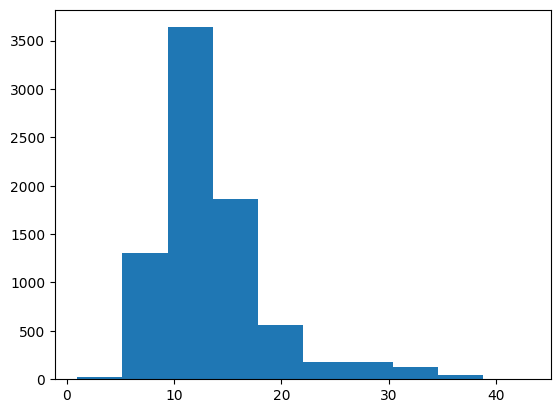

In [83]:
plt.hist(x=df['len'].values)

In [84]:
for i in range(0, 100, 10):
    print(f"{i}th percentile is {df['len'].quantile(i/100)}")

0th percentile is 1.0
10th percentile is 9.0
20th percentile is 10.0
30th percentile is 11.0
40th percentile is 11.0
50th percentile is 12.0
60th percentile is 13.0
70th percentile is 14.0
80th percentile is 16.0
90th percentile is 19.0


In [85]:
for i in range(91, 101, 1):
    print(f"{i}th percentile is {df['len'].quantile(i/100)}")

91th percentile is 19.0
92th percentile is 20.0
93th percentile is 21.0
94th percentile is 23.0
95th percentile is 25.0
96th percentile is 27.0
97th percentile is 29.0
98th percentile is 31.0
99th percentile is 33.0
100th percentile is 43.0


In [86]:
# define maximum length of a text
max_len = 25

In [87]:
# library for progress bar
from tqdm import notebook

# create an empty list to save integer sequence
sent_id = []

# iterate over each tweet
for i in notebook.tqdm(range(len(text))):

  encoded_sent = tokenizer.encode(text[i],
                                  add_special_tokens = True,
                                  max_length = max_len,
                                  truncation = True,
                                  pad_to_max_length='right')

  # saving integer sequence to a list
  sent_id.append(encoded_sent)

  0%|          | 0/7920 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [88]:
print("Integer Sequence:",sent_id[0])

Integer Sequence: [101, 4344, 16550, 10032, 3231, 11924, 18726, 3376, 10140, 2740, 1045, 15776, 18059, 2239, 2135, 18059, 8464, 18059, 102, 0, 0, 0, 0, 0, 0]


In [89]:
# create attention masks
attention_masks = []

# for each sentence...
for sent in sent_id:
  att_mask = [int(token_id > 0) for token_id in sent]

  # store the attention mask for this sentence.
  attention_masks.append(att_mask)

##3.4 Training and Validation Data

In [90]:
# Use train_test_split to split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sent_id, labels, random_state=2018, test_size=0.1, stratify=labels)

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1, stratify=labels)

##3.5 Define Dataloaders



In [91]:
# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [92]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

#define a batch size
batch_size = 32

# Create the DataLoader for our training set.
#Dataset wrapping tensors.
train_data = TensorDataset(train_inputs, train_masks, train_labels)

#define a sampler for sampling the data during training
  #random sampler samples randomly from a dataset
  #sequential sampler samples sequentially, always in the same order
train_sampler = RandomSampler(train_data)

#represents a iterator over a dataset. Supports batching, customized data loading order
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
#Dataset wrapping tensors.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

#define a sequential sampler
#This samples data in a sequential order
validation_sampler = SequentialSampler(validation_data)

#create a iterator over the dataset
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [93]:
#create an iterator object
iterator = iter(train_dataloader)

#loads batch data
sent_id, mask, target=next(iterator)

In [94]:
sent_id.shape

torch.Size([32, 25])

In [95]:
sent_id

tensor([[  101, 18059,  6594,  7249,  1998,  2074,  3564,  2182,  5983, 24593,
         18059, 20330,  2182,  6207,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2106,  2025,  2031, 18059,  6680,  2296,  2305, 18059,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 20228, 20363,  3687,  2746,  2574,  2327,  2762,  1998,  2327,
          2088,  8412,  8827,  2078,  8412, 20228, 20363,  8369,  2088,  2762,
         11870,  3363,  3617,  3102,   102],
        [  101, 13354, 18059,  3715,  2099,  1998,  4471, 16949,  3038, 13003,
          2025,  3569,  2007,  2023, 25339,  2092,  2054,  2842,  2064,   102,
             0,     0,     0,     0,     0],
        [  101,  2043,  6097,  7288,  3844,  2091,  1996,  2690,  5702,  1057,
          5603,  6207,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0, 

In [96]:
#pass inputs to the model
outputs = bert(sent_id,             #integer sequence
               attention_mask=mask, return_dict=False) #attention masks

In [97]:
# hidden states
hidden_states = outputs[0]

# [CLS] hidden state
CLS_hidden_state = outputs[1]

print("Shape of Hidden States:",hidden_states.shape)
print("Shape of CLS Hidden State:",CLS_hidden_state.shape)

Shape of Hidden States: torch.Size([32, 25, 768])
Shape of CLS Hidden State: torch.Size([32, 768])


#4. Model Finetuning

*The pretrained model is trained on the general domain corpus. So, finetuning the pretrained model helps in the capturing the domain specific features from our custom dataset*


Every pretrained model is trained using 2 different layers : **BackBone and Head**

* Backbone refers to the pretrained model architecture
* Head refers to the dense layer added on top of backbone. Generally, this layer is used for the classification tasks.

Hence, we can finetune the pretrained model in 2 ways

**1. Fine-Tuning only Head (or Dense Layer)**

1.1  CLS token

1.2  Hidden states


**2. Fine-Tuning both Backbone & Head**

1.1  CLS token

1.2  Hidden states


### 4.1 Approach: Fine-Tuning Only Head

As the name suggests, in this approach, we freeze the backbone and train only the head or dense layer.

### Steps to Follow

1. Turn off Gradients

2. Define Model Architecture

3. Define Optimizer and Loss

4. Define Train and Evaluate

5. Train the model

6. Evaluate the model




In [98]:
# turn off the gradient of all the parameters
for param in bert.parameters():
    param.requires_grad = False

##4.2 Define Model Architecture


In [102]:
#importing nn module
import torch.nn as nn

class classifier(nn.Module):

    #define the layers and wrappers used by model
    def __init__(self, bert):

      #constructor
      super(classifier, self).__init__()

      #bert model
      self.bert = bert

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      #dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #dropout layer
      self.dropout = nn.Dropout(0.1)

      #relu activation function
      self.relu =  nn.ReLU()

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      all_hidden_states, cls_hidden_state = self.bert(sent_id, attention_mask=mask, return_dict=False)

      #pass CLS hidden state to dense layer
      x = self.fc1(cls_hidden_state)

      #Apply ReLU activation function
      x = self.relu(x)

      #Apply Dropout
      x = self.dropout(x)

      #pass input to the output layer
      x = self.fc2(x)

      #apply softmax activation
      x = self.softmax(x)

      return x

In [103]:
#create the model
model = classifier(bert)

#push the model to GPU, if available
model = model.to(device)

In [104]:
#model architecture
model

classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [105]:
# push the tensors to GPU
sent_id = sent_id.to(device)
mask = mask.to(device)
target = target.to(device)

# pass inputs to the model
outputs = model(sent_id, mask)

In [106]:
# understand outputs
print(outputs)

tensor([[-0.8604, -0.5499],
        [-0.8440, -0.5621],
        [-0.8791, -0.5364],
        [-0.8563, -0.5529],
        [-0.7898, -0.6050],
        [-0.9150, -0.5117],
        [-0.8455, -0.5610],
        [-0.8878, -0.5303],
        [-0.8018, -0.5951],
        [-0.8096, -0.5889],
        [-0.7872, -0.6072],
        [-0.8260, -0.5759],
        [-0.8810, -0.5351],
        [-0.8004, -0.5963],
        [-0.9599, -0.4828],
        [-0.8086, -0.5897],
        [-0.9339, -0.4993],
        [-0.8341, -0.5696],
        [-0.9067, -0.5173],
        [-0.9287, -0.5026],
        [-0.9108, -0.5145],
        [-0.9078, -0.5165],
        [-0.8442, -0.5620],
        [-0.8351, -0.5689],
        [-0.9469, -0.4909],
        [-0.8727, -0.5410],
        [-0.9495, -0.4893],
        [-0.8048, -0.5927],
        [-0.8860, -0.5315],
        [-0.8953, -0.5251],
        [-0.8967, -0.5241],
        [-0.8678, -0.5445]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [107]:
# no. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 394,754 trainable parameters


## 4.3 Define Optimizer and Loss function


In [108]:
# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

Text(0.5, 1.0, 'Class Distribution')

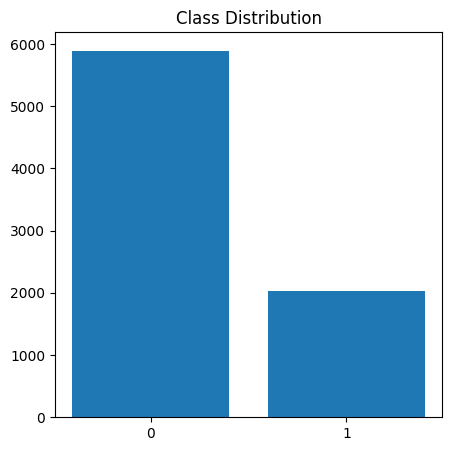

In [109]:
# understand the class distribution
keys=['0','1']

# set figure size
plt.figure(figsize=(5,5))

# plot bat chart
plt.bar(keys,class_counts)

# set title
plt.title('Class Distribution')

In [110]:
#library for array processing
import numpy as np

#library for computing class weights
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
#class_weights = compute_class_weight('balanced', np.unique(labels), y=labels)
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(labels), y= labels)

print("Class Weights:",class_weights)

Class Weights: [0.6718697  1.95459033]


In [111]:
# converting a list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# transfer to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

In [112]:
#compute the loss
print(target)
loss = cross_entropy(outputs, target)
print("Loss:",loss)

tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Loss: tensor(0.7403, device='cuda:0', grad_fn=<NllLossBackward0>)


In [113]:
import time
import datetime

# compute time in hh:mm:ss
def format_time(elapsed):
    # round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # format as hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_rounded))

## 4.4 Model Training and Evaluation

The deep learning model is trained in the form of epochs where in each epoch consists of several batches.

During training, for each batch, we need to

1. Perform Forward Pass
2. Compute Loss
3. Backpropagate Loss
4. Update Weights

Where as during evaluation, for each batch, we need to

1. Perform forward pass
2. Compute loss

```
Training: Epoch -> Batch -> Forward Pass -> Compute loss -> Backpropagate loss -> Update weights
```

```
Evaluation: Epoch -> Batch -> Forward Pass -> Compute loss
```

Hence, for each epoch, we have a training phase and a validation phase. After each batch we need to:

**Training phase**

1. Load data onto the GPU for acceleration

2. Unpack our data inputs and labels

3. Clear out the gradients calculated in the previous pass.

4. Forward pass (feed input data through the network)

5. Backward pass (backpropagation)

6. Update parameters with optimizer.step()

7. Track variables for monitoring progress




In [114]:
#define a function for training the model
def train():

  print("\nTraining.....")

  #set the model on training phase - Dropout layers are activated
  model.train()

  #record the current time
  t0 = time.time()

  #initialize loss and accuracy to 0
  total_loss, total_accuracy = 0, 0

  #Create a empty list to save the model predictions
  total_preds=[]

  #for every batch
  for step,batch in enumerate(train_dataloader):

    # Progress update after every 40 batches.
    if step % 40 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids
    #   [1]: attention masks
    #   [2]: labels
    sent_id, mask, labels = batch

    # Always clear any previously calculated gradients before performing a
    # backward pass. PyTorch doesn't do this automatically.
    model.zero_grad()

    # Perform a forward pass. This returns the model predictions
    preds = model(sent_id, mask)

    #compute the loss between actual and predicted values
    loss =  cross_entropy(preds, labels)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value
    # from the tensor.
    total_loss = total_loss + loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    #The model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    #Accumulate the model predictions of each batch
    total_preds.append(preds)

  #compute the training loss of a epoch
  avg_loss     = total_loss / len(train_dataloader)

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


**Evaluation phase**

1. Load data onto the GPU for acceleration

2. Unpack our data inputs and labels

3. Forward pass (feed input data through the network)

4. Compute loss on our validation data

5. Track variables for monitoring progress



In [115]:
#define a function for evaluating the model
def evaluate():

  print("\nEvaluating.....")

  #set the model on training phase - Dropout layers are deactivated
  model.eval()

  #record the current time
  t0 = time.time()

  #initialize the loss and accuracy to 0
  total_loss, total_accuracy = 0, 0

  #Create a empty list to save the model predictions
  total_preds = []

  #for each batch
  for step,batch in enumerate(validation_dataloader):

    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids
    #   [1]: attention masks
    #   [2]: labels
    sent_id, mask, labels = batch

    #deactivates autograd
    with torch.no_grad():

      # Perform a forward pass. This returns the model predictions
      preds = model(sent_id, mask)

      #compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      # Accumulate the validation loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value
      # from the tensor.
      total_loss = total_loss + loss.item()

      #The model predictions are stored on GPU. So, push it to CPU
      preds=preds.detach().cpu().numpy()

      #Accumulate the model predictions of each batch
      total_preds.append(preds)

  #compute the validation loss of a epoch
  avg_loss = total_loss / len(validation_dataloader)

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

##4.5 Train the Model

In [148]:
#Assign the initial loss to infinite
best_valid_loss = float('inf')

#create a empty list to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs = 20

#for each epoch
for epoch in range(epochs):

    print('\n....... epoch {:} / {:} .......'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    #accumulate training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

print("")
print("Training complete!")


....... epoch 1 / 20 .......

Training.....
  Batch    40  of    223.    Elapsed: 0:00:02.
  Batch    80  of    223.    Elapsed: 0:00:04.
  Batch   120  of    223.    Elapsed: 0:00:06.
  Batch   160  of    223.    Elapsed: 0:00:08.
  Batch   200  of    223.    Elapsed: 0:00:10.

Evaluating.....

Training Loss: 0.370
Validation Loss: 0.349

....... epoch 2 / 20 .......

Training.....
  Batch    40  of    223.    Elapsed: 0:00:02.
  Batch    80  of    223.    Elapsed: 0:00:04.
  Batch   120  of    223.    Elapsed: 0:00:06.
  Batch   160  of    223.    Elapsed: 0:00:08.
  Batch   200  of    223.    Elapsed: 0:00:10.

Evaluating.....

Training Loss: 0.373
Validation Loss: 0.335

....... epoch 3 / 20 .......

Training.....
  Batch    40  of    223.    Elapsed: 0:00:02.
  Batch    80  of    223.    Elapsed: 0:00:04.
  Batch   120  of    223.    Elapsed: 0:00:06.
  Batch   160  of    223.    Elapsed: 0:00:08.
  Batch   200  of    223.    Elapsed: 0:00:10.

Evaluating.....

Training Loss: 0.3

##4.6 Model Evaluation

In [149]:
# load weights of best model
path='saved_weights.pt'
model.load_state_dict(torch.load(path))

<ipython-input-149-f275889ef879>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [150]:
# get the model predictions on the validation data
# returns 2 elements- Validation loss and Predictions
valid_loss, preds = evaluate()
print(valid_loss)


Evaluating.....
0.3132805567979813


In [151]:
# Converting the log(probabities) into a classes
# Choosing index of a maximum value as class
y_pred = np.argmax(preds,axis=1)

# actual labels
y_true = validation_labels

In [152]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90       589
           1       0.65      0.92      0.76       203

    accuracy                           0.85       792
   macro avg       0.81      0.87      0.83       792
weighted avg       0.89      0.85      0.86       792



In [153]:
# y_true

In [154]:
# y_pred

In [155]:
preds

array([[-1.9940348 , -0.14635038],
       [-2.5711706 , -0.07952598],
       [-0.02983489, -3.5269592 ],
       ...,
       [-0.16745098, -1.8696222 ],
       [-2.5192475 , -0.08394712],
       [-1.3469344 , -0.301154  ]], dtype=float32)

# Test

In [156]:
df_test = pd.read_csv('/content/drive/MyDrive/Gen AI/BERT/test.csv')
df_test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks
1,7922,currently shitting my fucking pants. #apple #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/
2,7923,"I'd like to puts some CD-ROMS on my iPad, is that possible?' — Yes, but wouldn't that block the screen?\n"
3,7924,"My ipod is officially dead. I lost all my pictures and videos from the 1D and 5sos concert,and from Vet Camp #hatinglife #sobbing"
4,7925,Been fighting iTunes all night! I only want the music I $&@*# paid for


In [157]:
df_test.shape

(1953, 2)

In [158]:
# perform text cleaning
df_test['cleaned_tweet']= df_test['tweet'].apply(cleaner)
df_test.head()

,id,tweet,cleaned_tweet
0,7921,I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks,hate the new iphone upgrade won let download apps ugh apple sucks
1,7922,currently shitting my fucking pants. #apple #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/,currently shitting fucking pants apple imac cashmoney raddest swagswagswag
2,7923,"I'd like to puts some CD-ROMS on my iPad, is that possible?' — Yes, but wouldn't that block the screen?\n",like puts some roms ipad that possible yes but would not that block the screen
3,7924,"My ipod is officially dead. I lost all my pictures and videos from the 1D and 5sos concert,and from Vet Camp #hatinglife #sobbing",ipod officially dead lost all pictures and videos from the and sos concert and from vet camp hatinglife sobbing
4,7925,Been fighting iTunes all night! I only want the music I $&@*# paid for,been fighting itunes all night only want the music censored paid for


In [159]:
text_test   = df_test['cleaned_tweet'].values


In [160]:
# library for progress bar
from tqdm import notebook

# create an empty list to save integer sequence
sent_id_text = []

# iterate over each tweet
for i in notebook.tqdm(range(len(text_test))):

  encoded_sent = tokenizer.encode(text_test[i],
                                  add_special_tokens = True,
                                  max_length = max_len,
                                  truncation = True,
                                  pad_to_max_length='right')

  # saving integer sequence to a list
  sent_id_text.append(encoded_sent)

  0%|          | 0/1953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [161]:
print("Integer Sequence:",sent_id_text[0])

Integer Sequence: [101, 5223, 1996, 2047, 18059, 12200, 2180, 2292, 8816, 18726, 1057, 5603, 6207, 19237, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [162]:
# create attention masks
attention_masks_text = []

# for each sentence...
for sent in sent_id_text:
  att_mask = [int(token_id > 0) for token_id in sent]

  # store the attention mask for this sentence.
  attention_masks_text.append(att_mask)

In [163]:
# Convert all inputs and labels into torch tensors, the required datatype for our model.
test_inputs = torch.tensor(sent_id_text)
test_masks = torch.tensor(attention_masks_text)

In [164]:
preds = model(test_inputs, test_masks)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [165]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

#define a batch size
batch_size = 32

# Create the DataLoader for our training set.
#Dataset wrapping tensors.
test_data = TensorDataset(test_inputs, test_masks)

#define a sampler for sampling the data during training
  #random sampler samples randomly from a dataset
  #sequential sampler samples sequentially, always in the same order
# train_sampler = RandomSampler(train_data)

#represents a iterator over a dataset. Supports batching, customized data loading order
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [166]:
#define a function for evaluating the model
def test():

  print("\nEvaluating.....")

  #set the model on training phase - Dropout layers are deactivated
  model.eval()

  #record the current time
  t0 = time.time()

  #initialize the loss and accuracy to 0
  total_loss, total_accuracy = 0, 0

  #Create a empty list to save the model predictions
  total_preds = []

  #for each batch
  for step,batch in enumerate(test_dataloader):

    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids
    #   [1]: attention masks
    #   [2]: labels
    sent_id, mask = batch

    #deactivates autograd
    with torch.no_grad():

      # Perform a forward pass. This returns the model predictions
      preds = model(sent_id, mask)

      #compute the validation loss between actual and predicted values
      # loss = cross_entropy(preds,labels)

      # Accumulate the validation loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value
      # from the tensor.
      # total_loss = total_loss + loss.item()

      #The model predictions are stored on GPU. So, push it to CPU
      preds=preds.detach().cpu().numpy()

      #Accumulate the model predictions of each batch
      total_preds.append(preds)

  #compute the validation loss of a epoch
  # avg_loss = total_loss / len(validation_dataloader)

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return total_preds

In [167]:
total_preds = test()


Evaluating.....
  Batch    40  of     62.    Elapsed: 0:00:02.


In [168]:
total_preds

array([[-2.5887835 , -0.07808191],
       [-0.95218635, -0.48759162],
       [-2.9810114 , -0.0520741 ],
       ...,
       [-2.3133643 , -0.10417002],
       [-1.8429031 , -0.17239933],
       [-0.3534515 , -1.2115349 ]], dtype=float32)

In [169]:
y_pred_test = np.argmax(total_preds,axis=1)

In [170]:
y_pred_test

array([1, 1, 1, ..., 1, 1, 0])

In [171]:
len(y_pred_test)

1953

In [172]:
df_test['label'] = y_pred_test
df_test.head()

,id,tweet,cleaned_tweet,label
0,7921,I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks,hate the new iphone upgrade won let download apps ugh apple sucks,1
1,7922,currently shitting my fucking pants. #apple #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/,currently shitting fucking pants apple imac cashmoney raddest swagswagswag,1
2,7923,"I'd like to puts some CD-ROMS on my iPad, is that possible?' — Yes, but wouldn't that block the screen?\n",like puts some roms ipad that possible yes but would not that block the screen,1
3,7924,"My ipod is officially dead. I lost all my pictures and videos from the 1D and 5sos concert,and from Vet Camp #hatinglife #sobbing",ipod officially dead lost all pictures and videos from the and sos concert and from vet camp hatinglife sobbing,1
4,7925,Been fighting iTunes all night! I only want the music I $&@*# paid for,been fighting itunes all night only want the music censored paid for,1


In [173]:
df_sub = df_test[['id', 'label']]

In [175]:
df_sub.to_csv('bert_sub2.csv', index=False)